In [1]:
# -*- coding: utf-8 -*-

In [18]:
from __future__ import print_function
from __future__ import division
from prettytable import PrettyTable
import textwrap
# from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys
import string
import subprocess
import cPickle
import editdistance
import nltk
import time
import math
from collections import Counter
import IPython
from IPython import display
from nltk.corpus import stopwords
from collections import defaultdict
from timeit import default_timer as timer
from matplotlib import rcParams
import networkx as nx
import dtw
import scipy.io.wavfile
from IPython.display import display
from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [98]:
def plot_specgram_words(wav_fname, words_dict=None):
    if not os.path.exists(wav_fname):
        print("wav file not found ...")

    fig = plt.figure()
    #fig.set_size_inches(18.5, 10.5)
    ax = fig.add_subplot(111)
    sr, wav_data = scipy.io.wavfile.read(wav_fname)
    _ = plt.specgram(wav_data, Fs=sr, cmap=plt.cm.gist_heat)
    
    print(len(wav_data))
    the_y_lim = ax.get_ylim()
    ax.set_ylim(the_y_lim[0]-200,the_y_lim[1]+200)
    
    plt.text(.1, the_y_lim[1]+200, "test", size=15, rotation=0.,
         ha="center", va="center",
#          bbox = dict(boxstyle="round",
#                      ec=(1., 0.5, 0.5),
#                      fc=(1., 0.8, 0.8),
#                      )
         )
    if words_dict:
        print("something")
    pass

6640


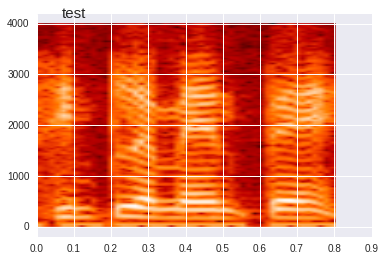

In [99]:
test_wav = u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n619.wav'
plot_specgram_words(test_wav)

In [45]:
!soxi $test_wav
IPython.display.Audio(test_wav)


Input File     : '../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n619.wav'
Channels       : 1
Sample Rate    : 8000
Precision      : 16-bit
Duration       : 00:00:00.83 = 6640 samples ~ 62.25 CDDA sectors
File Size      : 13.3k
Bit Rate       : 128k
Sample Encoding: 16-bit Signed Integer PCM



6880


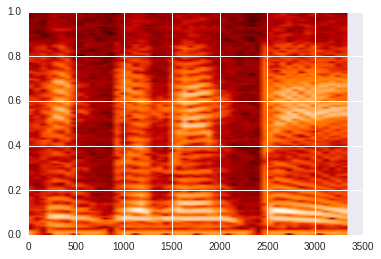

In [46]:
test_wav = u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n620.wav'
plot_specgram_words(test_wav)

In [47]:
!soxi $test_wav
IPython.display.Audio(test_wav)


Input File     : '../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n620.wav'
Channels       : 1
Sample Rate    : 8000
Precision      : 16-bit
Duration       : 00:00:00.86 = 6880 samples ~ 64.5 CDDA sectors
File Size      : 13.8k
Bit Rate       : 128k
Sample Encoding: 16-bit Signed Integer PCM

